# About Dataset

- **Origin**: Introduced by Mollahosseini et al. in _AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild_

- **Size & Labels**:  
  - Approximately 25,262 images  
  - Each image manually annotated for one of eight facial expressions:  **neutral, happy, angry, sad, fear, surprise, disgust, contempt** 
  - Continuous valence and arousal intensity scores

- **Purpose**: To study how facial expressions convey affect in unconstrained (“in the wild”) scenarios

- **Class Mapping**: Emotion labels mapped to integer IDs:  
  - **0** – Anger  
  - **1** – Contempt  
  - **2** – Disgust  
  - **3** – Fear  
  - **4** – Happy  
  - **5** – Neutral  
  - **6** – Sad  
  - **7** – Surprise

- **Link**: [Facial Expression Image Data AFFECTNET YOLO Format](https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format)

- **Splitation**:
  - train (0.7)
  - validation (0.2)
  - test (0.1)



# Exploratory Data Analysis

Import module:

In [21]:
from collections import Counter
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import numpy as np
import torch

Get dataset:

In [3]:
from utils.dataset import get_data_loaders
from torch.utils.data import ConcatDataset

train_loader, val_loader, test_loader, num_classes = get_data_loaders()
combined_loader = ConcatDataset([train_loader.dataset, val_loader.dataset, test_loader.dataset])

Data loaders created:
   Train: 17101 samples
   Validation: 5406 samples
   Test: 2755 samples
   Number of classes: 8


/home/veil/Documents/GitHub/cv-real-time-emotion-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Dataset Overview

### Number of samples:

In [4]:
print(f"Total number of samples: {len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)}")

print()

print(f"- Number of training samples: {len(train_loader.dataset)}")
print(f"- Number of validation samples: {len(val_loader.dataset)}")
print(f"- Number of test samples: {len(test_loader.dataset)}")

Total number of samples: 25262

- Number of training samples: 17101
- Number of validation samples: 5406
- Number of test samples: 2755


### List of emotion labels

In [5]:
emotion_labels = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
print("List of emotion labels:")
for idx, label in enumerate(emotion_labels):
    print(f"{idx}: {label}")

List of emotion labels:
0: Anger
1: Contempt
2: Disgust
3: Fear
4: Happy
5: Neutral
6: Sad
7: Surprise


## 2. Class Balance & Distribution

### Count per emotion

Counts per emotion:
Anger: 2339
Contempt: 1996
Disgust: 2242
Fear: 2021
Happy: 2154
Neutral: 1616
Sad: 1914
Surprise: 2819


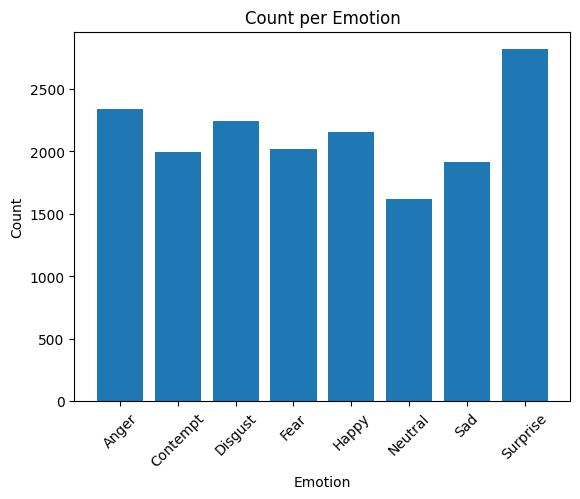

In [6]:
# Count occurrences of each emotion in the training dataset
emotion_counts = Counter()
for _, labels in train_loader:
    emotion_counts.update(labels.numpy())

# Print counts per emotion
print("Counts per emotion:")
for idx, label in enumerate(emotion_labels):
    print(f"{label}: {emotion_counts[idx]}")

# Plot the counts
plt.bar(emotion_labels, [emotion_counts[i] for i in range(num_classes)])
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Count per Emotion")
plt.xticks(rotation=45)
plt.show()

**Conclusion:** The dataset is relatively balanced across classes, with counts ranging from approximately 1600 to 2800 samples per class.

### Train/val/test splits

In [7]:
def calculate_class_proportions(data_loader):
    counts = Counter()
    total_samples = 0
    for _, labels in data_loader:
        counts.update(labels.numpy())
        total_samples += len(labels)
    proportions = {emotion_labels[i]: counts[i] / total_samples for i in range(num_classes)}
    return proportions

# Calculate proportions for each split
train_proportions = calculate_class_proportions(train_loader)
val_proportions = calculate_class_proportions(val_loader)
test_proportions = calculate_class_proportions(test_loader)

# Print proportions
print("Class Proportions:\n")
print(" - Training Split:")
for label, proportion in train_proportions.items():
    print(f"   + {label}: {proportion:.2%}")

print("\n - Validation Split:")
for label, proportion in val_proportions.items():
    print(f"   + {label}: {proportion:.2%}")

print("\n - Test Split:")
for label, proportion in test_proportions.items():
    print(f"   + {label}: {proportion:.2%}")

Class Proportions:

 - Training Split:
   + Anger: 13.68%
   + Contempt: 11.67%
   + Disgust: 13.11%
   + Fear: 11.82%
   + Happy: 12.60%
   + Neutral: 9.45%
   + Sad: 11.19%
   + Surprise: 16.48%

 - Validation Split:
   + Anger: 13.17%
   + Contempt: 11.43%
   + Disgust: 12.43%
   + Fear: 11.51%
   + Happy: 14.63%
   + Neutral: 9.51%
   + Sad: 11.15%
   + Surprise: 16.17%

 - Test Split:
   + Anger: 13.90%
   + Contempt: 12.05%
   + Disgust: 11.87%
   + Fear: 11.54%
   + Happy: 14.48%
   + Neutral: 9.07%
   + Sad: 10.09%
   + Surprise: 16.99%


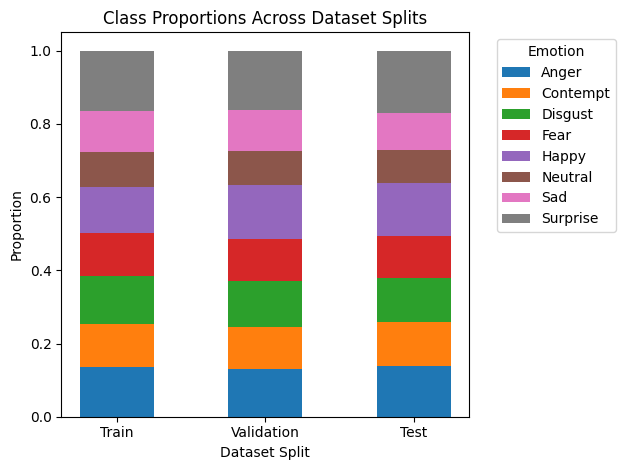

In [8]:
# Prepare data for the stacked bar chart
splits = ['Train', 'Validation', 'Test']
proportions = [train_proportions, val_proportions, test_proportions]
emotion_data = {emotion: [split[emotion] for split in proportions] for emotion in emotion_labels}

# Create the stacked bar chart
bar_width = 0.5
indices = np.arange(len(splits))

bottoms = np.zeros(len(splits))
for emotion, values in emotion_data.items():
    plt.bar(indices, values, bar_width, label=emotion, bottom=bottoms)
    bottoms += values

plt.xticks(indices, splits)
plt.xlabel('Dataset Split')
plt.ylabel('Proportion')
plt.title('Class Proportions Across Dataset Splits')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion:** The dataset is balanced in terms of label distribution across train, validation, and test splits.

## 3. Image-Level Summaries

### Pixel intensity statistics

Mean, median, std deviation across all pixels

In [22]:
combined_loader = DataLoader(combined_loader, batch_size=1024, shuffle=False, num_workers=4)

@torch.no_grad()  # disable gradient tracking for a bit of extra speed
def calculate_pixel_statistics(loader, device='cuda', bins=1000):
    # Put all accumulators on the GPU once
    total_sum    = torch.zeros((), device=device)
    total_sqsum  = torch.zeros((), device=device)
    total_pixels = 0
    global_min   = torch.full((), float('inf'), device=device)
    global_max   = torch.full((), float('-inf'), device=device)
    hist         = torch.zeros(bins, device=device, dtype=torch.long)

    for images, _ in loader:
        # 2) Move batch → GPU asynchronously, then flatten
        x = images.to(device, non_blocking=True).view(-1)

        # 3) Accumulate sum, sum of squares, counts
        total_sum   += x.sum()
        total_sqsum += (x * x).sum()
        total_pixels += x.numel()

        # 4) Track min/max
        global_min = torch.min(global_min, x.min())
        global_max = torch.max(global_max, x.max())

        # 5) Update histogram ON GPU
        #    torch.histc is a single fused kernel for equally spaced bins
        hist += torch.histc(x, bins=bins, min=0.0, max=1.0).to(torch.long)

    # 6) Finalize on CPU
    mean = (total_sum / total_pixels).item()
    var  = (total_sqsum / total_pixels - mean**2).item()
    std  = np.sqrt(var)
    global_min = global_min.item()
    global_max = global_max.item()

    # 7) Median from our fine-grained histogram
    hist_cpu = hist.cpu().numpy()
    edges = np.linspace(0.0, 1.0, bins + 1)
    cumsum = np.cumsum(hist_cpu)
    half = total_pixels // 2
    idx = np.searchsorted(cumsum, half, side='left')
    idx = min(idx, bins - 1)
    median = (edges[idx] + edges[idx + 1]) / 2.0

    return {
        'mean':   mean,
        'median': median,
        'std':    std,
        'min':    global_min,
        'max':    global_max
    }

# 8) Run it
stats = calculate_pixel_statistics(combined_loader)
print(f"Mean:   {stats['mean']:.4f}")
print(f"Median: {stats['median']:.4f}")
print(f"Std:    {stats['std']:.4f}")
print(f"Min:    {stats['min']:.4f}")
print(f"Max:    {stats['max']:.4f}")

Mean:   -0.0216
Median: 0.9995
Std:    0.5696
Min:    -1.0000
Max:    1.0000


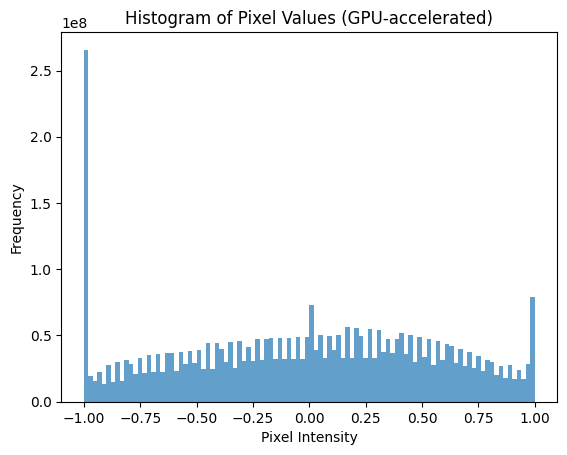

In [23]:
def compute_and_plot_histogram(loader, device='cuda', bins=100, min_val=-1.0, max_val=1.0):
    """
    Compute and plot a pixel‐intensity histogram entirely on GPU.
    
    Args:
        loader:     PyTorch DataLoader yielding (images, labels), images in [min_val, max_val].
        device:     'cuda' or 'cpu'.
        bins:       Number of equally spaced bins.
        min_val:    Lower bound of pixel intensity.
        max_val:    Upper bound of pixel intensity.
    """
    # 1) Prepare bin edges & centers on CPU
    edges = np.linspace(min_val, max_val, bins + 1)
    centers = (edges[:-1] + edges[1:]) / 2

    # 2) Allocate histogram accumulator on GPU
    hist_gpu = torch.zeros(bins, dtype=torch.long, device=device)

    # 3) Stream batches, update GPU histogram
    for images, _ in loader:
        x = images.to(device, non_blocking=True).view(-1)
        batch_hist = torch.histc(x, bins=bins, min=min_val, max=max_val).to(torch.long)
        hist_gpu += batch_hist

    # 4) Transfer result back to CPU and plot
    hist = hist_gpu.cpu().numpy()
    plt.bar(centers, hist, width=centers[1] - centers[0], alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values (GPU-accelerated)')
    plt.show()

compute_and_plot_histogram(combined_loader, device='cuda', bins=100, min_val=-1.0, max_val=1.0)

**Conclusion**:
 - **Extreme spikes at –1 and +1:** –1 comes from zero-valued (black) pixels (e.g. padding/background), +1 from saturated whites.

 - **Relatively flat mid-range between –0.9 and +0.9:** a broad spread of face/background intensities.

 - **Mean ≈0 vs. Median ≈0.9:** A massive –1 spike pulls the average down, while the large +1 mass pushes the median toward the top end.

### Per-class pixel stats

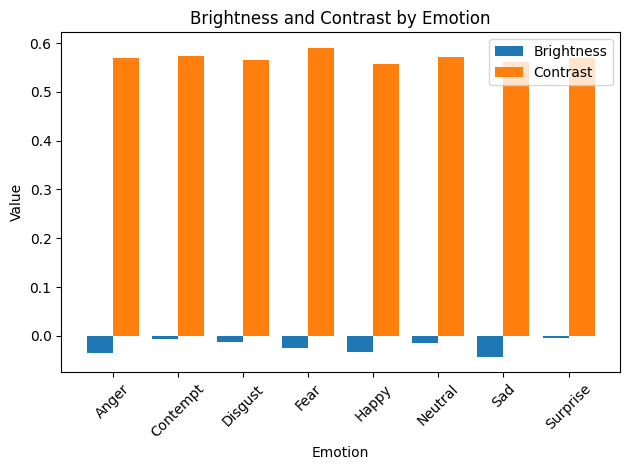

In [24]:
@torch.no_grad()
def calculate_brightness_contrast_by_emotion(loader, num_classes, device='cuda'):
    brightness = torch.zeros(num_classes, device=device)
    contrast = torch.zeros(num_classes, device=device)
    counts = torch.zeros(num_classes, device=device)

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        for i in range(num_classes):
            mask = labels == i
            if mask.any():
                pixels = images[mask].view(-1)
                brightness[i] += pixels.sum()
                contrast[i] += (pixels ** 2).sum()
                counts[i] += pixels.numel()

    brightness /= counts
    contrast = torch.sqrt(contrast / counts - brightness ** 2)

    return brightness.cpu().numpy(), contrast.cpu().numpy()

# Calculate brightness and contrast
brightness, contrast = calculate_brightness_contrast_by_emotion(combined_loader, num_classes)

# Plot brightness and contrast
x = np.arange(num_classes)
width = 0.4

plt.bar(x - width / 2, brightness, width, label='Brightness')
plt.bar(x + width / 2, contrast, width, label='Contrast')

plt.xticks(x, emotion_labels, rotation=45)
plt.xlabel('Emotion')
plt.ylabel('Value')
plt.title('Brightness and Contrast by Emotion')
plt.legend()
plt.tight_layout()
plt.show()

**Conclusion:**
 - **Overall dimness:** Every emotion has a slightly negative mean brightness (all blue bars sit just below zero), with Sad the darkest and Contempt/Surprise the brightest.

 - **Contrast spread:** Contrast (orange) ranges from about 0.53 up to 0.59—Fear images have the highest contrast, Sad the lowest.

 - **Take-away:** The global brightness/contrast differences between emotions are quite subtle. You’d likely need more localized or high-level features (e.g. landmark-based metrics or deep embeddings) rather than raw pixel stats alone to distinguish expressions.

### Channel-wise analysis (if RGB)

In [25]:
@torch.no_grad()
def calculate_channel_statistics(loader, device='cuda'):
    channel_sum = torch.zeros(3, device=device)
    channel_sqsum = torch.zeros(3, device=device)
    total_pixels = 0

    for images, _ in loader:
        images = images.to(device, non_blocking=True)
        total_pixels += images.numel() // 3  # Total pixels per channel
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_sqsum += (images ** 2).sum(dim=[0, 2, 3])

    mean = channel_sum / total_pixels
    std = torch.sqrt(channel_sqsum / total_pixels - mean ** 2)

    return mean.cpu().numpy(), std.cpu().numpy()

# Calculate channel-wise mean and std
channel_mean, channel_std = calculate_channel_statistics(combined_loader)

# Print results
print(f"Channel-wise Mean: {channel_mean}")
print(f"Channel-wise Std: {channel_std}")

Channel-wise Mean: [ 0.13444428 -0.05278233 -0.14731221]
Channel-wise Std: [0.59266335 0.5437353  0.5324993 ]


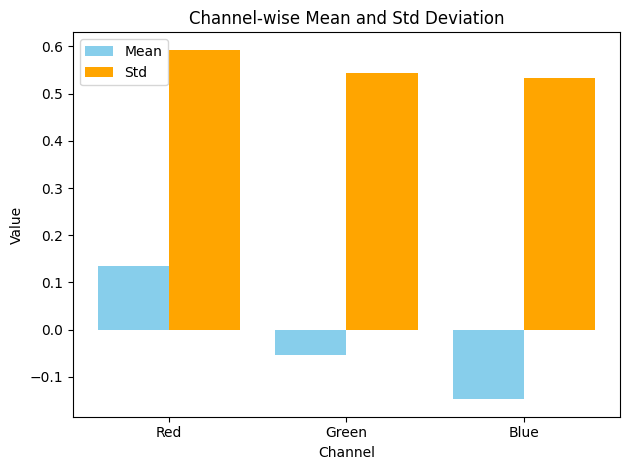

In [27]:
# Plot channel-wise mean and standard deviation
channels = ['Red', 'Green', 'Blue']
x = np.arange(len(channels))

plt.bar(x - width / 2, channel_mean, width, label='Mean', color='skyblue')
plt.bar(x + width / 2, channel_std, width, label='Std', color='orange')

plt.xticks(x, channels)
plt.xlabel('Channel')
plt.ylabel('Value')
plt.title('Channel-wise Mean and Std Deviation')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Visual Inspection

### Sample grid per class

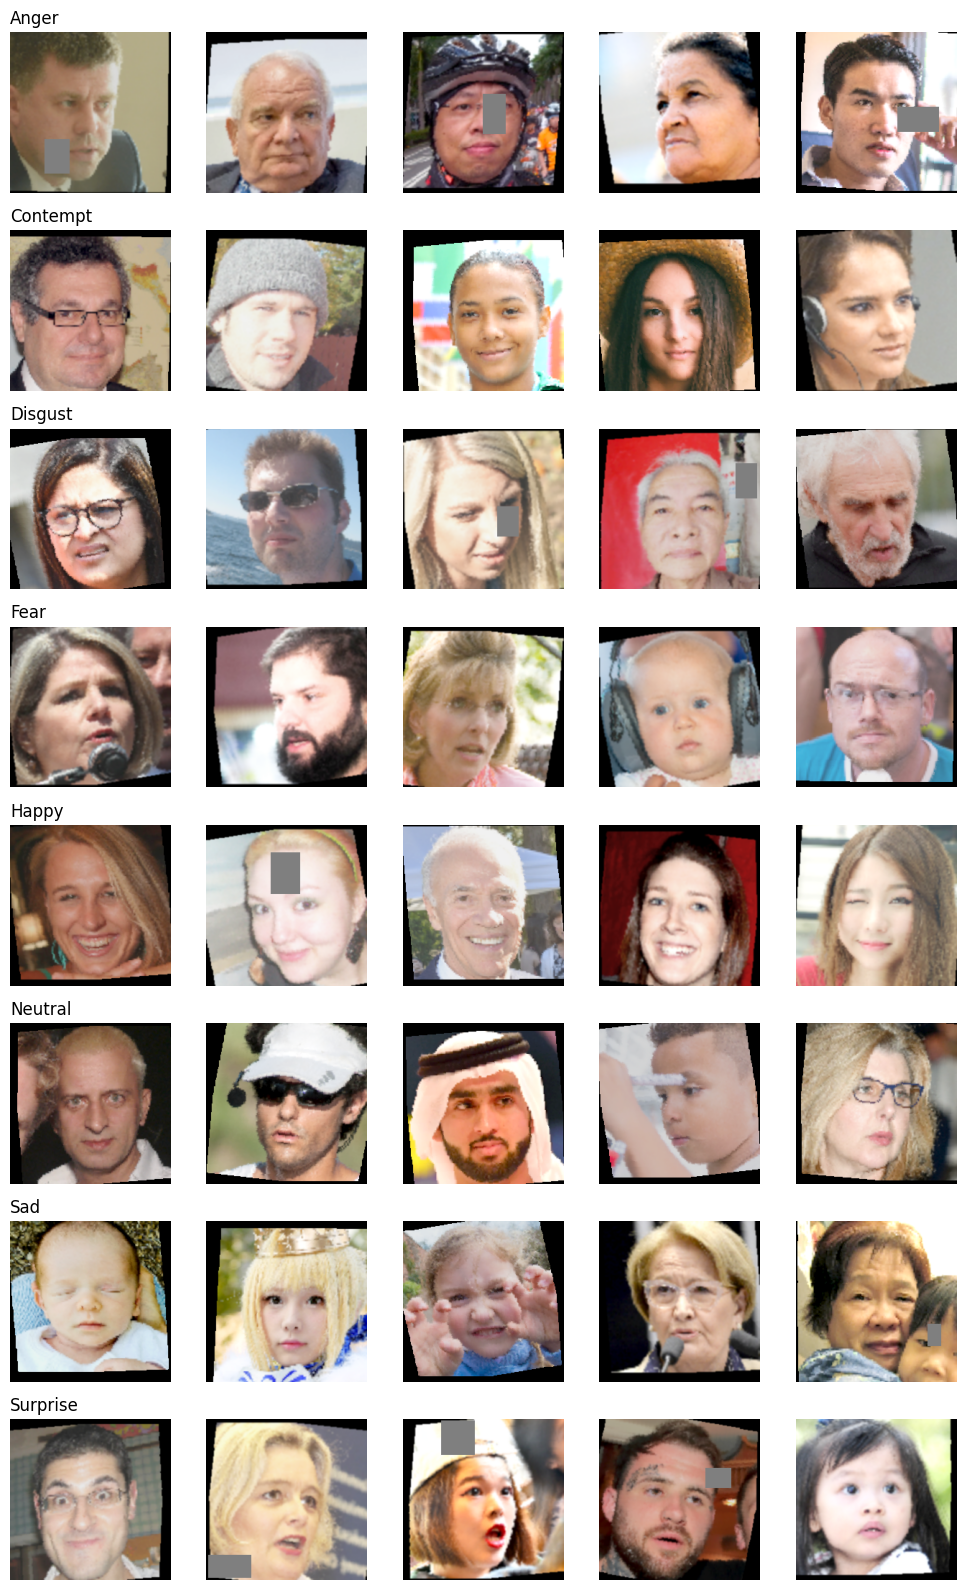

In [34]:
def plot_sample_grid_per_class_streaming(
    combined_loader,
    emotion_labels,
    samples_per_class=5,
    denormalize=True
):
    """
    Stream images from combined_loader into a pre-created grid,
    moving each image to CPU and plotting it immediately.
    This avoids ever storing more than one batch in RAM at once.
    """
    n_classes = len(emotion_labels)
    # prepare figure
    fig, axes = plt.subplots(
        n_classes,
        samples_per_class,
        figsize=(samples_per_class * 2, n_classes * 2),
        squeeze=False
    )

    # counters to know when each row is full
    counts = {cls: 0 for cls in emotion_labels}

    for images, labels in combined_loader:
        # move the whole batch to CPU and release GPU memory
        images = images.cpu()
        for img, lbl in zip(images, labels):
            cls = emotion_labels[lbl.item()]
            idx = counts[cls]
            if idx < samples_per_class:
                # denormalize if needed
                if denormalize:
                    img = img * 0.5 + 0.5
                # convert to HWC numpy
                img_np = img.permute(1, 2, 0).numpy()
                row = emotion_labels.index(cls)
                ax = axes[row][idx]
                ax.imshow(np.clip(img_np, 0, 1))
                ax.axis('off')
                if idx == 0:
                    ax.set_ylabel(cls, rotation=0, labelpad=40, va='center')
                    axes[row][0].set_title(cls, fontsize=12, loc='left')  # Add title at the start of the row
                counts[cls] += 1

        # break as soon as every class has enough samples
        if all(counts[cls] >= samples_per_class for cls in emotion_labels):
            break

    plt.tight_layout()
    plt.show()

plot_sample_grid_per_class_streaming(combined_loader, emotion_labels, samples_per_class=5)


## 5. Summary

1. **Dataset Balance**:
    - The dataset is relatively balanced across classes and splits, with no significant skew in label distribution.

2. **Pixel-Level Analysis**:
    - **Brightness and Contrast**:
      - Subtle differences in brightness and contrast exist between emotions.
      - Sad images are the darkest, while Contempt and Surprise are the brightest.
      - Fear images exhibit the highest contrast, while Sad images have the lowest.
    - **Histogram Analysis**:
      - Extreme spikes at -1 (black pixels) and +1 (white pixels) dominate the histogram.
      - A relatively flat mid-range indicates a broad spread of intensities.

3. **Channel-Wise Statistics**:
    - The RGB channels show distinct mean and standard deviation values, with the Red channel having the highest mean and variability.

4. **Visual Inspection**:
    - Sample grids reveal clear visual differences between emotion classes, supporting the dataset's diversity.

5. **Key Takeaways**:
    - While global pixel statistics provide insights, more localized or high-level features (e.g., landmarks or embeddings) are likely needed for effective emotion classification.
